# data1030 project
## EDA

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


In [2]:
# load everything in
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/Building_Permits.csv")
np.random.seed(0)

Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.


Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units',
       'Plansets', 'TIDF Compliance', 'Existing Construction Type',
       'Existing Construction Type Description', 'Proposed Construction Type',
       'Proposed Construction Type Description', 'Site Permit',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location', 'Record ID'],
     


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


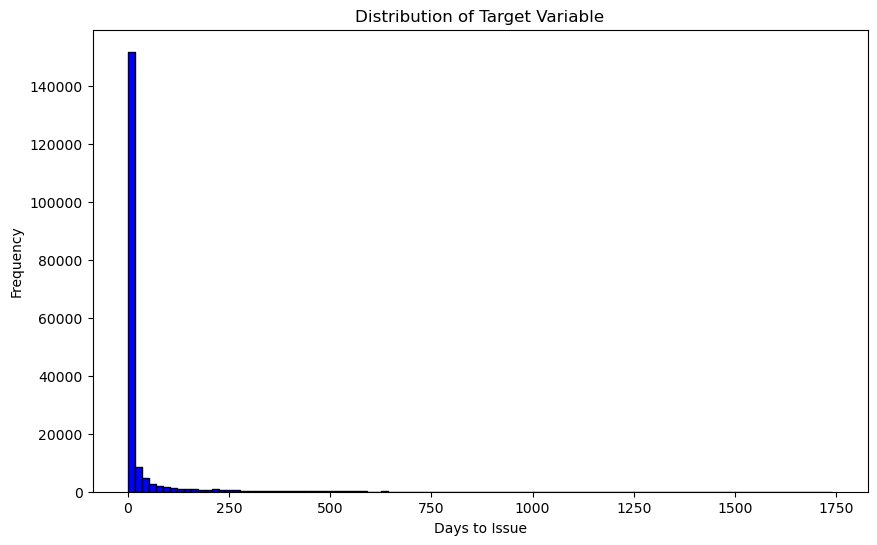

1740
26.054696673189824
0.0


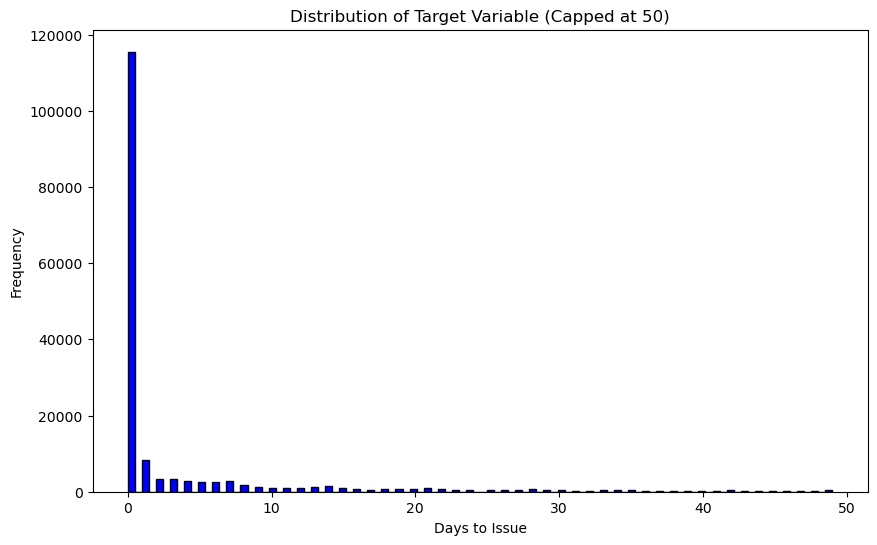

In [4]:
# get a glimpse of data
pd.set_option('display.max_columns', None)
df.sample(5)

# understand the shape of the data and the labels of the columns
print(df.columns)
print(len(df.index))
print(len(df.columns))
# calculating target variable column (number of days between filing a permit and being issued one)
df['days_to_issue'] = pd.to_datetime(df['Issued Date']) - pd.to_datetime(df['Filed Date'])
# setting that column as the "target variable"
target_var = df['days_to_issue']
for i in range(len(target_var)):
    target_var[i] = target_var[i].days
# converting dates to integer of days since 1/1/2013
for column in df.columns:
    if column.endswith('Date'):
        df[column] = df[column].apply(lambda x: (pd.to_datetime(x) - pd.to_datetime('2013-01-01')).days if x is not None else x)
# creating a histogram of the target variable
hist = target_var.plot(kind='hist', figsize=(10, 6), bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Target Variable')
plt.xlabel('Days to Issue')
plt.ylabel('Frequency')
plt.show()

# target_var description
print(target_var.max())
print(target_var.mean())
print(target_var.median())
# target variable ranges from 0 days to 997 days
# regression problem - predicting the number of days between filing a permit and being issued one

# capping target_var at 50 for viz purposes
target_var_50 = target_var.copy()
target_var_50 = target_var_50[target_var_50 < 50]
hist2 = target_var_50.plot(kind='hist', figsize=(10, 6), bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Target Variable (Capped at 50)')
plt.xlabel('Days to Issue')
plt.ylabel('Frequency')
plt.show()



In [5]:
target_var.value_counts()
#what percent of the target variable is 0?
percent_zero = target_var.value_counts()[0]/len(target_var)
# how many 0s are there in the target variable?
print(target_var.value_counts()[0])
print(percent_zero)

115488
0.580633484162896


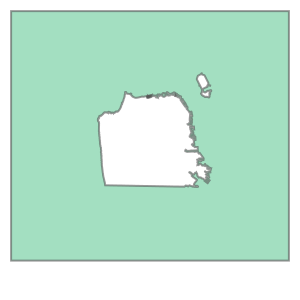

In [6]:
# geographic breakdown of the data
# using geopandas library to plot the data on a map of San Francisco
# https://towardsdatascience.com/making-heat-maps-with-literal-maps-how-to-use-python-to-construct-a-chloropleth-6b65e4e33905
sf_map = gpd.read_file("data/sfoutline.shp")
sf_map['geometry'][0]
# goal for the future...




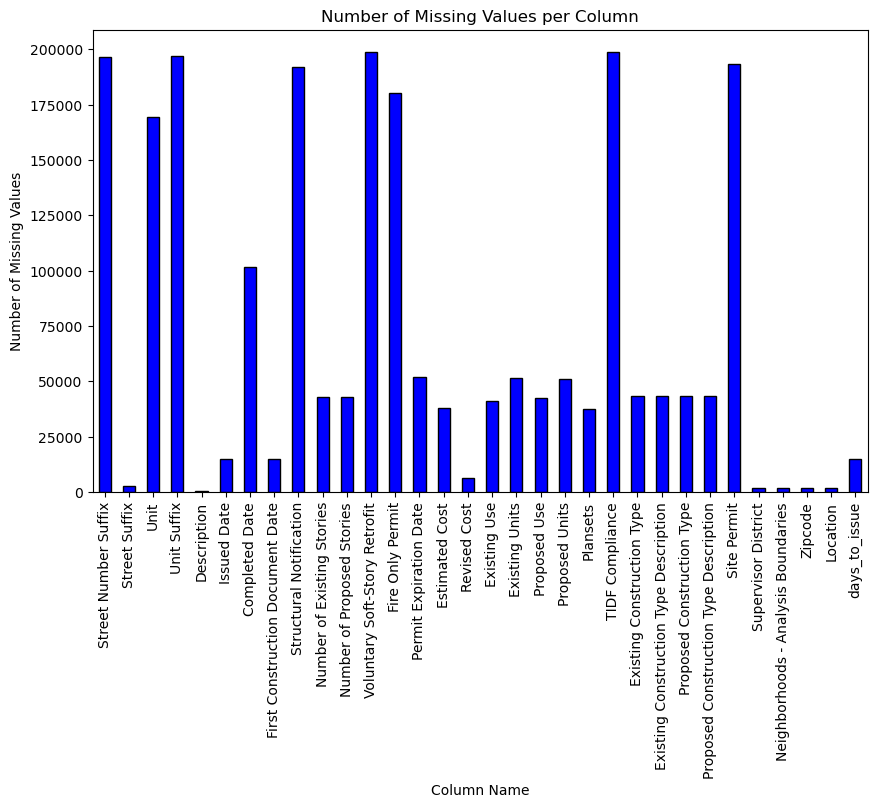

TIDF Compliance                  198898
Voluntary Soft-Story Retrofit    198865
Unit Suffix                      196939
Street Number Suffix             196684
Site Permit                      193541
Structural Notification          191978
Fire Only Permit                 180073
Unit                             169421
Completed Date                   101709
Permit Expiration Date            51880
dtype: int64
Proposed Units                    50911
Existing Units                    51538
Permit Expiration Date            51880
Completed Date                   101709
Unit                             169421
Fire Only Permit                 180073
Structural Notification          191978
Site Permit                      193541
Street Number Suffix             196684
Unit Suffix                      196939
Voluntary Soft-Story Retrofit    198865
TIDF Compliance                  198898
dtype: int64
0.25833916083916086
2260881
8751600


In [7]:
missing_value_count = df.isnull().sum()
# plotting missing values by column
missing_value_count[missing_value_count > 0].plot(kind='bar', figsize=(10, 6), color='blue', edgecolor='black')
plt.title('Number of Missing Values per Column')
plt.xlabel('Column Name')
plt.ylabel('Number of Missing Values')
plt.show()

# printing 10 columns with most missing values
print(missing_value_count.sort_values(ascending=False).head(10))
# only 12 columns without missing values
print(missing_value_count.sort_values(ascending=True).tail(12))
# total percentage of empty cells
print(missing_value_count.sum()/(len(df.index)*len(df.columns)))
print(missing_value_count.sum())
print(len(df.index)*len(df.columns))
# 26% of cells are empty

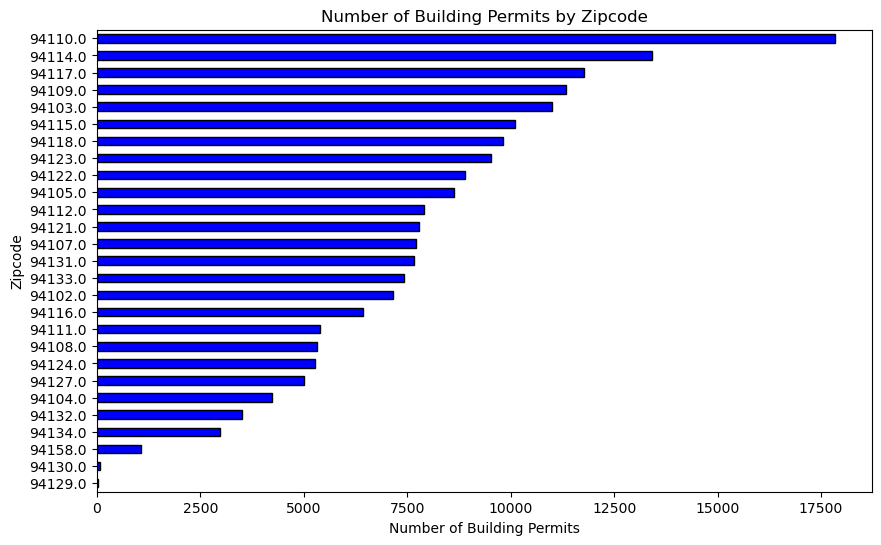

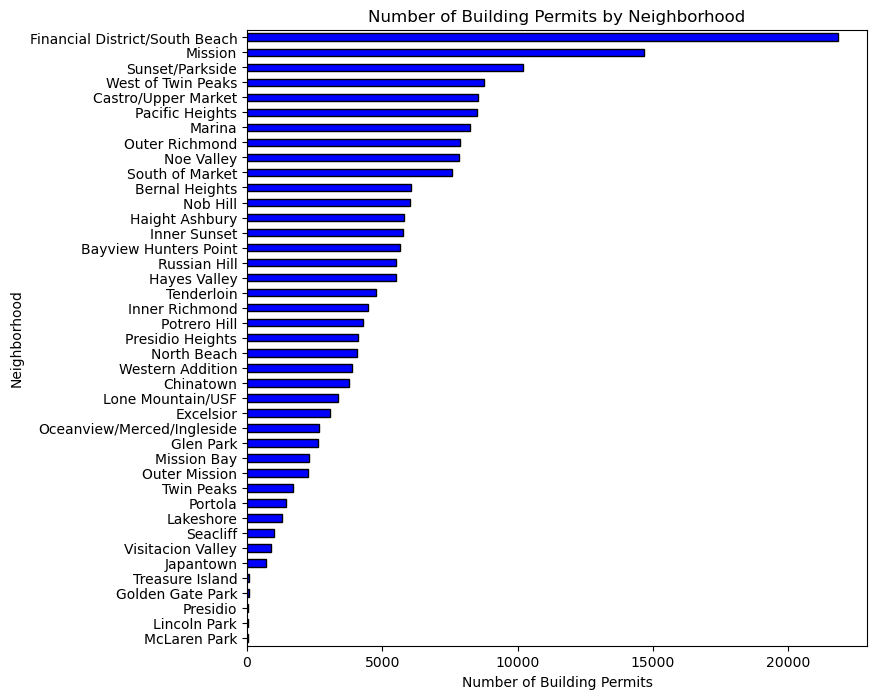

In [8]:
# bar plot of # of building permits by zipcode
df['Zipcode'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='blue', edgecolor='black')
plt.title('Number of Building Permits by Zipcode')
plt.xlabel('Number of Building Permits')
plt.ylabel('Zipcode')
plt.show()

# bar plot of # of building permits by neighborhood
df['Neighborhoods - Analysis Boundaries'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(8, 8), color='blue', edgecolor='black')
plt.title('Number of Building Permits by Neighborhood')
plt.xlabel('Number of Building Permits')
plt.ylabel('Neighborhood')
plt.show()

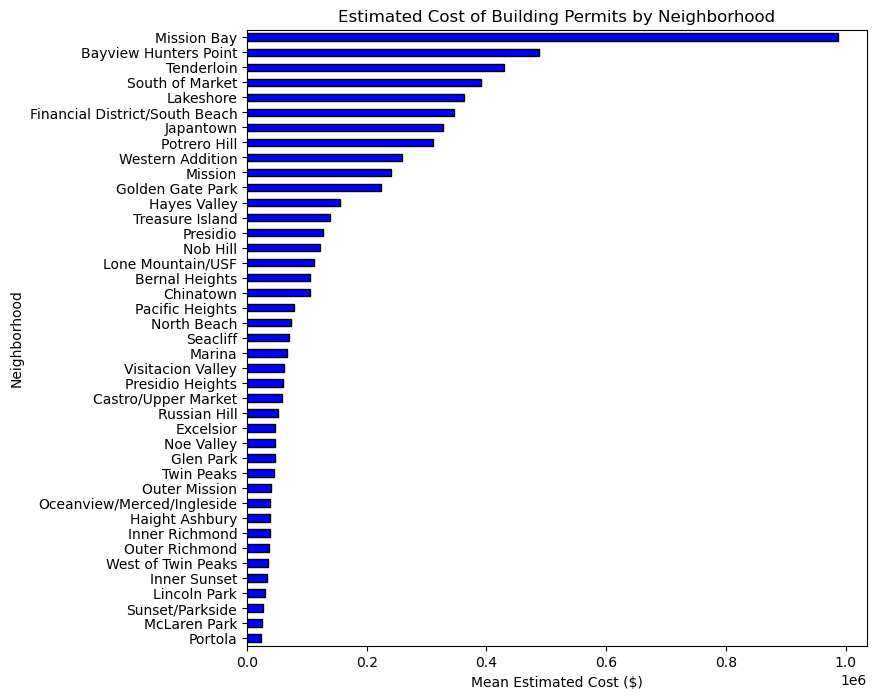

Neighborhoods - Analysis Boundaries
Mission Bay                       986416.468203
Bayview Hunters Point             487010.991886
Tenderloin                        429540.259706
South of Market                   391403.944213
Lakeshore                         362270.375591
Financial District/South Beach    345188.666637
Japantown                         328012.295082
Potrero Hill                      310990.056164
Western Addition                  259131.716567
Mission                           241151.031765
Golden Gate Park                  224320.189655
Hayes Valley                      155384.108458
Treasure Island                   138222.728148
Presidio                          126518.250000
Nob Hill                          121293.007845
Lone Mountain/USF                 111467.638040
Bernal Heights                    105492.505652
Chinatown                         104996.394490
Pacific Heights                    78648.127577
North Beach                        74224.623492
Seac

In [9]:
# bar plot of estimated cost by neighborhood
df.groupby('Neighborhoods - Analysis Boundaries')['Estimated Cost'].mean().sort_values(ascending=True).plot(kind='barh', figsize=(8, 8), color='blue', edgecolor='black')
plt.title('Estimated Cost of Building Permits by Neighborhood')
plt.xlabel('Mean Estimated Cost ($)')
plt.ylabel('Neighborhood')
plt.show()
print(df.groupby('Neighborhoods - Analysis Boundaries')['Estimated Cost'].mean().sort_values(ascending=False))


# -----------------------------------------------------
## SPLITTING + PREPROCESSING
# -----------------------------------------------------

In [ ]:
# split function
def basic_split(X, y, train_size, val_size, test_size, random_state):
    if (train_size+val_size+test_size) != 1:
        raise ValueError("train_size, val_size, and test_size must sum to 1")
    if not isinstance(random_state, int):
        raise ValueError("random_state must be an integer")
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X must be a DataFrame")
    if not isinstance(y, pd.Series):
        raise ValueError("y must be a Series")
    if len(X) != len(y):
        raise ValueError("X and y must have the same length")
    X_train, X_temp, y_train, y_temp =\
        train_test_split(X, y, train_size=train_size, random_state=random_state)
    X_val, X_test, y_val, y_test =\
        train_test_split(X_temp, y_temp, test_size=\
            test_size/(1-train_size), random_state=random_state)
    if len(X_train) != int(train_size*len(X)) and len(X_train) !=\
          int(train_size*len(X))+1 and len(X_train) !=\
              int(train_size*len(X))-1:
        raise ValueError("train_size is incorrect in the outputs")
    if len(X_val) != int(val_size*len(X)) and len(X_val) !=\
          int(val_size*len(X))+1 and len(X_val) !=\
              int(val_size*len(X))-1:
        raise ValueError("val_size is incorrect in the outputs")
    if len(X_test) != int(test_size*len(X)) and len(X_test) !=\
          int(test_size*len(X))+1 and len(X_test) !=\
              int(test_size*len(X))-1:
        raise ValueError("test_size is incorrect in the outputs")
    return X_train, X_val, X_test, y_train, y_val, y_test

#setting feature matrix + target variable
X = df.drop('days_to_issue', axis=1)
y = df['days_to_issue']

#establishing random state
random_state = 42

#splitting data into train, val, and test sets
split_data = train_test_split(X, y, random_state)
X_train, X_val, X_test, y_train, y_val, y_test = split_data

# checking that the split is correct
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(X_train)/len(X) == 0.6)
print(len(X_val)/len(X) == 0.2)
print(len(X_test)/len(X) == 0.2)

In [ ]:
mvc = X_train.isnull().sum() / len(X_train)
print(X_train.shape)
# identify columns with greater than 50% missing values
mvc[mvc > 0.5]
columns_to_remove = mvc[mvc > 0.5].index
print(columns_to_remove)
for column in columns_to_remove:
    X_train.drop(column, axis=1, inplace=True)
    X_val.drop(column, axis=1, inplace=True)
    X_test.drop(column, axis=1, inplace=True)

# remove rows that do not have an issued date and as such don't have a target variable
X_train = X_train[X_train['Issued Date'].notnull()]
X_val = X_val[X_val['Issued Date'].notnull()]
X_test = X_test[X_test['Issued Date'].notnull()]

In [ ]:
# preprocessing

# for column in X_train.columns:
#     if column.endswith('Date'):
#         X_train[column] = X_train[column].apply(lambda x: (pd.to_datetime(x)-pd.to_datetime("01/01/2013")).days if pd.notnull(x) else x)
# for column in X_val.columns:
#     if column.endswith('Date'):
#         X_val[column] = X_val[column].apply(lambda x: (pd.to_datetime(x)-pd.to_datetime("01/01/2013")).days if pd.notnull(x) else x)
# for column in X_test.columns:
#     if column.endswith('Date'):
#         X_test[column] = X_test[column].apply(lambda x: (pd.to_datetime(x)-pd.to_datetime("01/01/2013")).days if pd.notnull(x) else x)
# print(X_train.dtypes)
onehot_ftrs = ['Permit Type', 'Permit Type Definition', 'Current Status', 'Existing Use', 'Proposed Use', 'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode']
minmax_ftrs = ['Permit Creation Date', 'Current Status Date', 'First Construction Document Date', 'Permit Expiration Date']
std_ftrs = ['Number of Existing Stories', 'Number of Proposed Stories', 'Estimated Cost', 'Revised Cost', 'Existing Units', 'Proposed Units', 'Plansets']

preprocessor = ColumnTransformer(
    transformers=[
        # ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(X_train.shape)
print(X_train_prep.shape)
print(X_train_prep)

print(X_train.isnull().sum())


# X_train_prep.head()


In [4]:
new_df = pd.read_csv("data/Building_Permits.csv")
new_df['days_to_issue'] = pd.to_datetime(new_df['Issued Date']) - pd.to_datetime(new_df['Filed Date'])
# setting that column as the "target variable"
target_var = new_df['days_to_issue']
for i in range(len(target_var)):
    target_var[i] = target_var[i].days
# converting dates to integer of days since 1/1/2013
for column in new_df.columns:
    if column.endswith('Date'):
        new_df[column] = new_df[column].apply(lambda x: (pd.to_datetime(x) - pd.to_datetime('2013-01-01')).days if x is not None else x)

new_df = new_df[new_df['Issued Date'].notnull()]
mvc = new_df.isnull().sum() / len(new_df)
columns_to_remove = mvc[mvc > 0.5].index
new_df.drop(columns_to_remove, axis=1, inplace=True)
random_state = 42

# random subset for speed purposes
new_df = new_df.sample(n=1000)

X = new_df.drop('days_to_issue', axis=1)
y = new_df['days_to_issue']





# X_train_prep = clf.fit_transform(X_train)
# X_val_prep = clf.transform(X_val)
# X_test_prep = clf.transform(X_test)

# print(X_train.shape)
# print(X_train_prep.shape)
# print(X_train_prep)

# print(X_train.isnull().sum())


Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
# for column in X.columns:
#     if X[column].dtype == 'float64':
#         X[column] = pd.to_numeric(X[column], errors='coerce', downcast='integer')


print(len(new_df))

# function that takes in a column and outputs a column with every float value changed to an integer
# and every na value left the same
def float_to_int(column):
    return column.apply(lambda x: int(x) if not pd.isna(x) else np.nan)

for column in X.columns:
    if X[column].dtype == 'float64':
        X[column] = float_to_int(X[column])


1000


In [6]:
# print(X.columns)
print(columns_to_remove)
# print(X.dtypes)
X.head()
# new_df.dtypes


Index(['Street Number Suffix', 'Unit', 'Unit Suffix',
       'Structural Notification', 'Voluntary Soft-Story Retrofit',
       'Fire Only Permit', 'TIDF Compliance', 'Site Permit'],
      dtype='object')


,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Name,Street Suffix,Description,...,Plansets,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
44106,M477327,8,otc alterations permit,461,2697,033,298,Collingwood,St,street space,...,NaN,NaN,NaN,NaN,NaN,8.0,Castro/Upper Market,94114.0,"(37.75773072802721, -122.43609590384054)",1337805277707
66885,M535047,8,otc alterations permit,674,0121,005,1030,Green,St,street space,...,NaN,NaN,NaN,NaN,NaN,3.0,Russian Hill,94133.0,"(37.79886463892355, -122.41621852010499)",1361649294264
187652,M850107,8,otc alterations permit,1764,1423,002,205,10th,Av,street space,...,NaN,NaN,NaN,NaN,NaN,1.0,Inner Richmond,94118.0,"(37.78439081623724, -122.46908476549532)",148544299089
19697,201307252795,8,otc alterations permit,205,3502,098,31,Elgin,Pk,to comply with nov 201310561 for dry rot on re...,...,0.0,5.0,wood frame (5),5.0,wood frame (5),8.0,Mission,94103.0,"(37.770933721053716, -122.42305599766243)",1312223418695
26318,M430069,8,otc alterations permit,269,5586,001,25,Dorman,Av,"add address to block 5586, lot001 as; 5,15,25,...",...,NaN,NaN,NaN,NaN,NaN,10.0,Bayview Hunters Point,94124.0,"(37.73941959955102, -122.40270550930157)",1319146493665


In [54]:
from sklearn.impute import SimpleImputer
onehot_ftrs = ['Permit Type Definition', 'Current Status', 'Existing Use', 'Proposed Use', 'Neighborhoods - Analysis Boundaries']
minmax_ftrs = ['Permit Type', 'Supervisor District', 'Permit Creation Date', 'Current Status Date', 'First Construction Document Date', 'Permit Expiration Date', 'Zipcode']
std_ftrs = ['Number of Existing Stories', 'Number of Proposed Stories', 'Estimated Cost', 'Revised Cost', 'Existing Units', 'Proposed Units', 'Plansets']

minmax_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('minmax', MinMaxScaler())
])

std_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='mean')),
    ('std', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer3', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])



preprocessor = ColumnTransformer(
    transformers=[
        # ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('minmax', minmax_transformer, minmax_ftrs),
        ('std', std_transformer, std_ftrs),
        ('cat', categorical_transformer, onehot_ftrs)
    ])

prep = Pipeline(steps=[('preprocessor', preprocessor)])

xgboost_prep = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs),
        ('cat', OneHotEncoder(handle_unknown='ignore'), onehot_ftrs)
    ]
)

xgboost_pipe = Pipeline(steps=[('xgboost_prep', xgboost_prep)])

In [8]:
new_df.dtypes


Permit Number                              object
Permit Type                                 int64
Permit Type Definition                     object
Permit Creation Date                        int64
Block                                      object
Lot                                        object
Street Number                               int64
Street Name                                object
Street Suffix                              object
Description                                object
Current Status                             object
Current Status Date                         int64
Filed Date                                  int64
Issued Date                               float64
Completed Date                            float64
First Construction Document Date          float64
Number of Existing Stories                float64
Number of Proposed Stories                float64
Permit Expiration Date                    float64
Estimated Cost                            float64


In [11]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

def MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.

    You should:

    1. Loop through 10 different random states
    2. Split your data 
    3. Fit a model using GridSearchCV with KFold and the predefined Preprocessor 
    4. Calculate the model's error on the test set 
    5. Return a list of 10 test scores and 10 best models 
    '''
    
    # lists to be returned 
    test_scores = []
    best_models = []

    print(f"running {ML_algo}...")
    rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

    # your code here...
    # 1. loop through 10 different random states
    for random_state in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        # 2. split the data
        X_other, X_test, y_other, y_test = train_test_split(X, y,\
                                        test_size=0.2, random_state = random_state)
        kf = KFold(n_splits=4, shuffle=True, random_state=random_state)
        pipe = make_pipeline(preprocessor, ML_algo)
        # 3. fit a model using GridSearchCV with KFold and the predefined Preprocessor
        model = RandomizedSearchCV(pipe, param_grid, scoring=rmse, cv=kf, error_score='raise')
        model.fit(X_other, y_other)
        best_models.append(model)
        # 4. calculate the model's error on the test set
        test_score = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
        test_scores.append(test_score)

    return test_scores, best_models

param_grids = {
    'Lasso': {'lasso__alpha': np.logspace(-3, 3, 7)},
    'Ridge': {'ridge__alpha': np.logspace(-3, 3, 7)},
    'ElasticNet': {'elasticnet__alpha': np.logspace(-3, 3, 7),
                   'elasticnet__l1_ratio': [0.2, 0.5, 0.8]},
    'RandomForest': {'randomforestregressor__n_estimators': [10, 50, 100],
                     'randomforestregressor__max_depth': [10, 20]},
    'SVR': {'svr__C': np.logspace(-3, 3, 7),
            'svr__gamma': ['scale', 'auto']},
    'KNN': {'kneighborsregressor__n_neighbors': [1, 3, 5, 10]},
    'XGBoost': {'xgbregressor__n_estimators': [10, 50, 100],
                'xgbregressor__max_depth': [10, 20]}
}

lasso_model = Lasso(random_state=42, max_iter=1000000)
ridge_model = Ridge(random_state=42, max_iter=1000000)
elasticnet_model = ElasticNet(random_state=42, max_iter=1000000)
randomforest_model = RandomForestRegressor(random_state=42)
svr_model = SVR()
knn_model = KNeighborsRegressor()

l1_test_scores, l1_best_models = MLpipe_KFold_RMSE(X, y, prep,\
                                            lasso_model, param_grids['Lasso'])
l2_test_scores, l2_best_models = MLpipe_KFold_RMSE(X, y, prep,\
                                            ridge_model, param_grids['Ridge'])
en_test_scores, en_best_models = MLpipe_KFold_RMSE(X, y, prep,\
                                            elasticnet_model, param_grids['ElasticNet'])
rf_test_scores, rf_best_models = MLpipe_KFold_RMSE(X, y, prep,\
                                            randomforest_model, param_grids['RandomForest'])
svr_test_scores, svr_best_models = MLpipe_KFold_RMSE(X, y, prep,\
                                            svr_model, param_grids['SVR'])
knn_test_scores, knn_best_models = MLpipe_KFold_RMSE(X, y, prep,\
                                            knn_model, param_grids['KNN'])
print(f"Mean L1 Test RMSE: {np.mean(l1_test_scores)}")
print(f"Standard Deviation of L1 Test RMSE: {np.std(l1_test_scores)}")
print('\n')
print(f"Mean L2 Test RMSE: {np.mean(l2_test_scores)}")
print(f"Standard Deviation of L2 Test RMSE: {np.std(l2_test_scores)}")
print('\n')
print(f"Mean Elastic Net Test RMSE: {np.mean(en_test_scores)}")
print(f"Standard Deviation of Elastic Net Test RMSE: {np.std(en_test_scores)}")
print('\n')
print(f"Mean Random Forest Test RMSE: {np.mean(rf_test_scores)}")
print(f"Standard Deviation of Random Forest Test RMSE: {np.std(rf_test_scores)}")
print('\n')
print(f"Mean SVR Test RMSE: {np.mean(svr_test_scores)}")
print(f"Standard Deviation of SVR Test RMSE: {np.std(svr_test_scores)}")
print('\n')
print(f"Mean KNN Test RMSE: {np.mean(knn_test_scores)}")
print(f"Standard Deviation of KNN Test RMSE: {np.std(knn_test_scores)}")

running Lasso(max_iter=1000000, random_state=42)...


The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The tota

running Ridge(max_iter=1000000, random_state=42)...


The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
The tota

running ElasticNet(max_iter=1000000, random_state=42)...
running RandomForestRegressor(random_state=42)...


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The tota

running SVR()...
running KNeighborsRegressor()...


The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
The tota

Mean L1 Test RMSE: 22.697813803670055
Standard Deviation of L1 Test RMSE: 4.52558702054455


Mean L2 Test RMSE: 23.91796334136921
Standard Deviation of L2 Test RMSE: 5.224360619517141


Mean Elastic Net Test RMSE: 47.592929645065404
Standard Deviation of Elastic Net Test RMSE: 17.848701239972314


Mean Random Forest Test RMSE: 67.78880215086707
Standard Deviation of Random Forest Test RMSE: 16.82214982736526


Mean SVR Test RMSE: 70.32542063188387
Standard Deviation of SVR Test RMSE: 22.840498239482663


Mean KNN Test RMSE: 74.80098291480991
Standard Deviation of KNN Test RMSE: 19.88822479594077


In [30]:
l1_test_scores
baseline_result = np.mean(y)
baseline_score = np.sqrt\
    (mean_squared_error(y, np.repeat(baseline_result, len(y))))
print(f"Baseline RMSE score is {baseline_score}")
# print(l1_test_scores)
# print(np.mean(l1_test_scores))


Baseline RMSE score is 96.04524931510149


In [23]:
from xgboost import XGBRegressor

param_grids = {
    'Lasso': {'lasso__alpha': np.logspace(-3, 3, 7)},
    'Ridge': {'ridge__alpha': np.logspace(-3, 3, 7)},
    'ElasticNet': {'elasticnet__alpha': np.logspace(-3, 3, 7),
                   'elasticnet__l1_ratio': [0.2, 0.5, 0.8]},
    'RandomForest': {'randomforestregressor__n_estimators': [10, 50, 100],
                     'randomforestregressor__max_depth': [10, 20]},
    'SVR': {'svr__C': np.logspace(-3, 3, 7),
            'svr__gamma': ['scale', 'auto']},
    'KNN': {'kneighborsregressor__n_neighbors': [1, 3, 5, 10]},
    'XGBoost': {'xgbregressor__n_estimators': [10, 50, 100],
                'xgbregressor__max_depth': [10, 20]}
}

xgb_test_scores, xgb_best_models = MLpipe_KFold_RMSE(X, y, xgboost_pipe,\
                                            XGBRegressor(), param_grids['XGBoost'])

running XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)...


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
The tota

In [24]:
print(f"Mean XGB Test RMSE: {np.mean(xgb_test_scores)}")
print(f"Standard Deviation of XGB Test RMSE: {np.std(xgb_test_scores)}")

Mean XGB Test RMSE: 69.99252375562075
Standard Deviation of XGB Test RMSE: 16.565961873507355


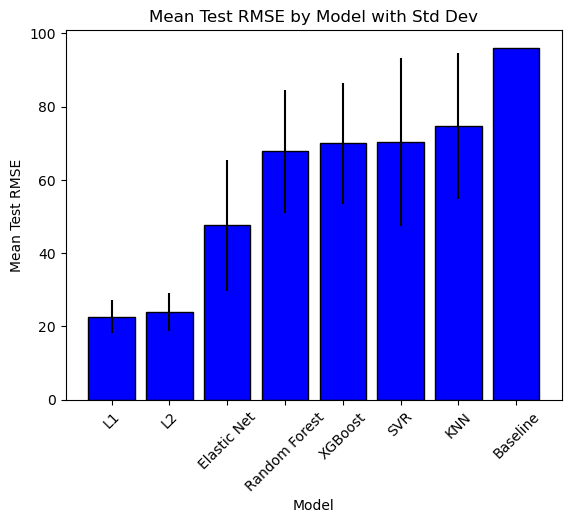

In [25]:
# plot all the test scores and standard deviations in a bar chart

results_df = pd.DataFrame({'Model': ['L1', 'L2', 'Elastic Net', 'Random Forest', 'SVR', 'KNN', 'XGBoost', 'Baseline'],\
    'Mean Test RMSE': [np.mean(l1_test_scores), np.mean(l2_test_scores), np.mean(en_test_scores),\
        np.mean(rf_test_scores), np.mean(svr_test_scores), np.mean(knn_test_scores),\
            np.mean(xgb_test_scores), baseline_score],\
    'Std Dev': [np.std(l1_test_scores), np.std(l2_test_scores), np.std(en_test_scores),\
        np.std(rf_test_scores), np.std(svr_test_scores), np.std(knn_test_scores),\
            np.std(xgb_test_scores), 0]})

results_df.sort_values(by='Mean Test RMSE', inplace=True)

plt.bar(results_df['Model'], results_df['Mean Test RMSE'], yerr=results_df['Std Dev'],
        color='blue', edgecolor='black')
# reorder bar chart from smallest to largest mean RMSE

plt.xticks(rotation=45)

plt.title('Mean Test RMSE by Model with Std Dev')
plt.xlabel('Model')
plt.ylabel('Mean Test RMSE')
plt.show()

In [81]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
lasso_model = Lasso(random_state=42, max_iter=1000000)


param_grids = {
    'Lasso': {'lasso__alpha': np.logspace(-3, 3, 7)},
    'Ridge': {'ridge__alpha': np.logspace(-3, 3, 7)},
    'ElasticNet': {'elasticnet__alpha': np.logspace(-3, 3, 7),
                   'elasticnet__l1_ratio': [0.2, 0.5, 0.8]},
    'RandomForest': {'randomforestregressor__n_estimators': [10, 50, 100],
                     'randomforestregressor__max_depth': [10, 20]},
    'SVR': {'svr__C': np.logspace(-3, 3, 7),
            'svr__gamma': ['scale', 'auto']},
    'KNN': {'kneighborsregressor__n_neighbors': [1, 3, 5, 10]},
    'XGBoost': {'xgbregressor__n_estimators': [10, 50, 100],
                'xgbregressor__max_depth': [10, 20]}
}

def MLpipe_KFold_RMSE_Lasso(X, y, preprocessor, ML_algo, param_grid, random_state):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.

    You should:

    1. Loop through 10 different random states
    2. Split your data 
    3. Fit a model using GridSearchCV with KFold and the predefined Preprocessor 
    4. Calculate the model's error on the test set 
    5. Return a list of 10 test scores and 10 best models 
    '''
    
    # lists to be returned 
    # test_scores = []
    # best_models = []

    print(f"running {ML_algo}...")
    rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

    # your code here...
    # 1. loop through 10 different random states
        # 2. split the data
    X_other, X_test, y_other, y_test = train_test_split(X, y,\
                                    test_size=0.2, random_state = random_state)
    kf = KFold(n_splits=4, shuffle=True, random_state=random_state)
    pipe = make_pipeline(preprocessor, ML_algo)
    # 3. fit a model using GridSearchCV with KFold and the predefined Preprocessor
    model = RandomizedSearchCV(pipe, param_grid, scoring=rmse, cv=kf, error_score='raise')
    model.fit(X_other, y_other)
    feature_names = model.best_estimator_[0].get_feature_names_out()

    # 4. calculate the model's error on the test set
    test_score = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    best_model = model

    return test_score, best_model, np.array(feature_names), X_other, y_other, X_test, y_test

l1_test_scores, l1_best_models, feature_names, X_other, y_other, X_test, y_test = MLpipe_KFold_RMSE_Lasso(X, y, prep,\
                                            lasso_model, param_grids['Lasso'], 42)



running Lasso(max_iter=1000000, random_state=42)...


The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.


In [82]:
print(l1_test_scores)
print(l1_best_models.best_estimator_[1])
# understand how to use X_test as masker for SHAP linear explainer

X_train_prep = prep.fit_transform(X_other)
X_test_prep = prep.transform(X_test)


25.173840929528684
Lasso(alpha=0.1, max_iter=1000000, random_state=42)


In [79]:
X_test_prep
# for i in range(len(X_test.iloc[0])):
#     type_list = pd.Series(X_test.iloc[i].dtypes)
#     print(type_list.unique().sum())

<200x116 sparse matrix of type '<class 'numpy.float64'>'
	with 3637 stored elements in Compressed Sparse Row format>

In [ ]:

print(len(X_test))
print(len(y_test))
y_pred = l1_best_models.predict(X_test)
print(len(y_pred))
print(type(X_test))
print(type(y_test))
print(type(y_pred))
y_pred = pd.Series(y_pred)
print(type(y_pred))
print(X_test.columns)


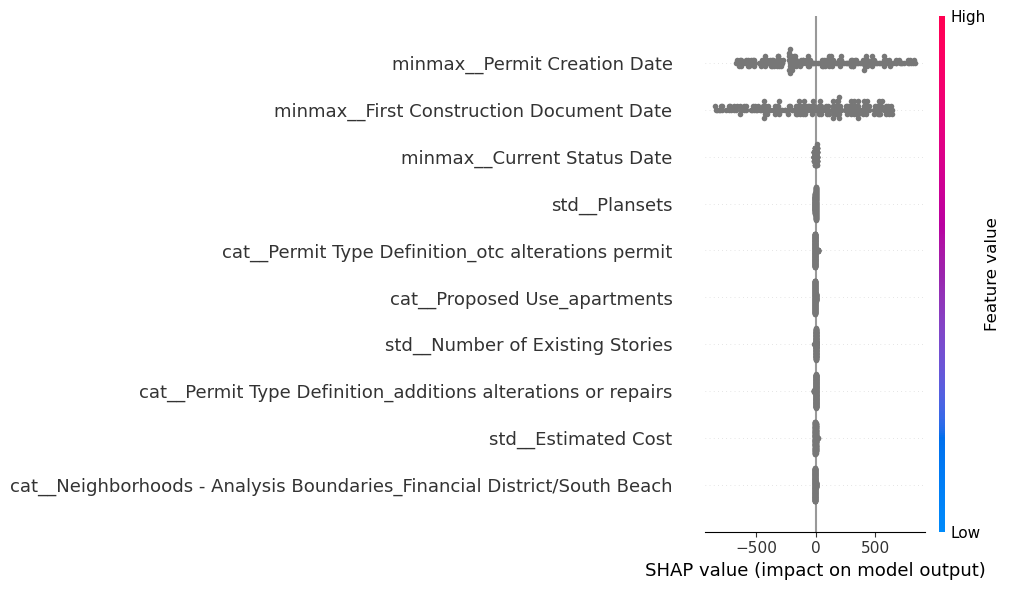

In [102]:
import shap
shap.initjs()
explainer = shap.LinearExplainer(l1_best_models.best_estimator_[1], X_test_prep)

X_test_transformed = l1_best_models.best_estimator_[0].transform(X_test)
shap_values = explainer.shap_values(X_test_transformed)

index = 5

# shap.force_plot(explainer.expected_value, shap_values[index], X_test_transformed[index], feature_names=feature_names)
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, max_display=10, plot_size=(10,6))

Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


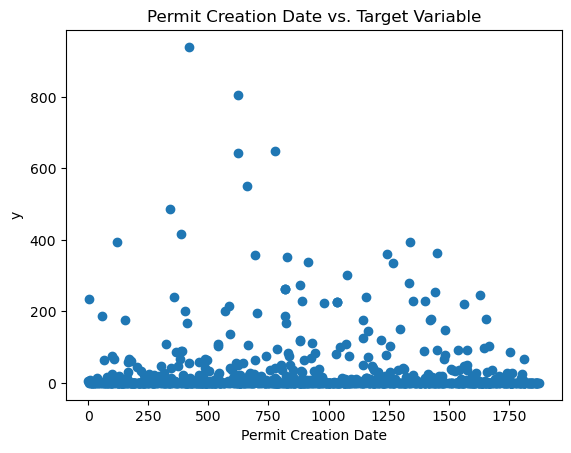

Block


In [115]:
new_df = pd.read_csv("data/Building_Permits.csv")
new_df['days_to_issue'] = pd.to_datetime(new_df['Issued Date']) - pd.to_datetime(new_df['Filed Date'])
# setting that column as the "target variable"
target_var = new_df['days_to_issue']
for i in range(len(target_var)):
    target_var[i] = target_var[i].days
# converting dates to integer of days since 1/1/2013
for column in new_df.columns:
    if column.endswith('Date'):
        new_df[column] = new_df[column].apply(lambda x: (pd.to_datetime(x) - pd.to_datetime('2013-01-01')).days if x is not None else x)

new_df = new_df[new_df['Issued Date'].notnull()]
mvc = new_df.isnull().sum() / len(new_df)
columns_to_remove = mvc[mvc > 0.5].index
new_df.drop(columns_to_remove, axis=1, inplace=True)
random_state = 42

# random subset for speed purposes
new_df = new_df.sample(n=1000)

X = new_df.drop('days_to_issue', axis=1)
y = new_df['days_to_issue']

# plot change in target variable as a function of value of minmax_PermitCreationDate
pcd = X['Permit Creation Date']
plt.scatter(pcd, y)
plt.title('Permit Creation Date vs. Target Variable')
plt.xlabel('Permit Creation Date')
plt.ylabel('y')
plt.show()
print(min(X))


# X = X['PermitCreationDate']
# plt.scatter(X, y)
# plt.xlabel('minmax_PermitCreationDate')
# plt.ylabel('y')
# plt.show()
